積分時間はこの範囲で設定してください
0 < Ti < 0.060045

Kp=  3.0588
Ti=  0.0300
Td=  0.0185
Gain crossover frequency= 30.00rad/s
Phase margin= 30.00deg

Kp=  3.0588
Ti=  0.0400
Td=  0.0093
Gain crossover frequency= 30.00rad/s
Phase margin= 30.00deg

Kp=  3.0588
Ti=  0.0500
Td=  0.0037
Gain crossover frequency= 30.00rad/s
Phase margin= 30.00deg



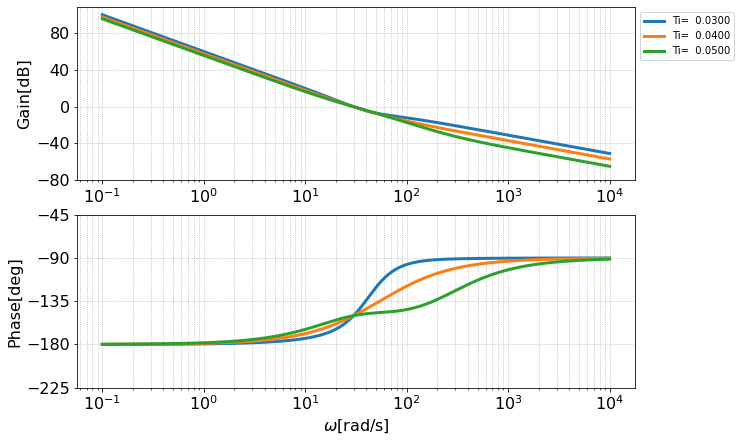

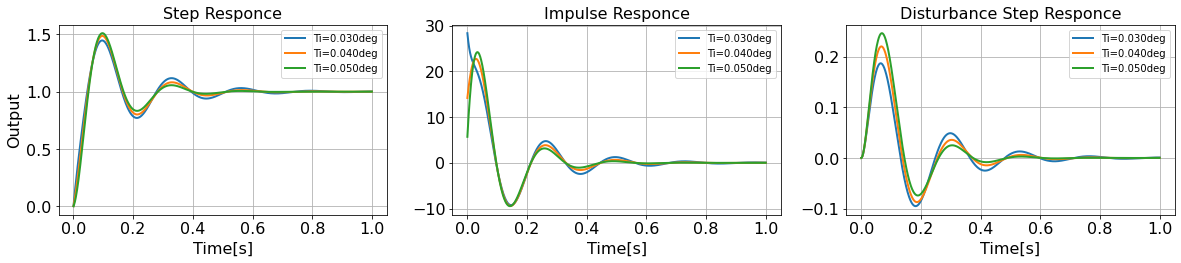

In [1]:
import numpy as np
import control.matlab as matlab
import matplotlib.pyplot as plt

#制御対象作成（Python-control使用）
tau=0.02 #制御対象の時定数
K=10.0 #制御対象のゲイン

#制御対象の伝達関数モデル生成
##制御対象のモデルに合わせて適切に以下を修正する必要があります。
Plant=matlab.tf([K],[tau,1,0])

#①位相余裕𝑃𝑀とゲイン交差周波数𝜔_𝑐を決める
PM=30*np.pi/180
omega_c=30

#②位相余裕𝑃𝑀の時の位相 𝜙_𝑚を計算する
phi_m=PM-np.pi

#③制御対象の周波数伝達関数を求める
#pythonではz=1+2*1jの様に複素数が使えます
Plant_freq=K/(omega_c*1j)/(tau*1j*omega_c+1)

#④制御対象の周波数伝達関数からの𝜔_𝑐の時の実部𝑢の値と虚部𝑣の値を求める
u=Plant_freq.real
v=Plant_freq.imag

#⑤（f）式から比例ゲインを求める
Kp=(u*np.cos(phi_m)+v*np.sin(phi_m))/(u**2+v**2)

#⑥積分時間を適当に決めて（d）式から微分時間を求める
Tis=np.array([0.03, 0.04, 0.05])
Tds=1/omega_c**2/Tis - (v-u*np.tan(phi_m))/omega_c/(u+v*np.tan(phi_m))

#⑦求めたゲインで周波数応答、ステップ応答、インパルス応答、外乱からの応答等を見る。
#良くなければ⑥にもどる。良ければ終了
Kps=np.ones(len(Tis))*Kp
print('積分時間はこの範囲で設定してください')
if (v-u*np.tan(phi_m))/omega_c/(u+v*np.tan(phi_m))>0:
    print('0 < Ti < {:f}\n'.format((u+v*np.tan(phi_m))/omega_c/(v-u*np.tan(phi_m))))
else:
    print('Ti>0\n')

fig1=plt.figure(figsize=(10,7))
fig2=plt.figure(figsize=(20,3.5))
ax1=fig1.add_subplot(2,1,1)
ax2=fig1.add_subplot(2,1,2)

ax3=fig2.add_subplot(1,3,1)
ax4=fig2.add_subplot(1,3,2)
ax5=fig2.add_subplot(1,3,3)

for Kp,Ti,Td in zip(Kps, Tis, Tds):    
    Controller=matlab.tf([Kp*Td, Kp, Kp/Ti],[1,0])
    Loop=Plant*Controller
    closesys=matlab.feedback(Loop)

    #位相余裕（ゲイン余裕）
    gm, pm, wpc, wgc=matlab.margin(Loop)
    print('Kp={:8.4f}'.format(Kp))
    print('Ti={:8.4f}'.format(Ti))
    print('Td={:8.4f}'.format(Td))

    print('Gain crossover frequency={:6.2f}rad/s'.format(wgc))
    print('Phase margin={:6.2f}deg\n'.format(pm))

    wfreq=np.logspace(-1,4,1000)

    #開ループボード線図
    magq,phaseq,omegaq = matlab.bode(Loop,wfreq,plot=False)
    ax1.semilogx(omegaq,20*np.log10(magq), lw=3,label='Ti={:8.4f}'.format(Ti))
    #ax1.semilogx(wgc,20*np.log10(1),marker='o')
    ax2.semilogx(omegaq,phaseq*180/np.pi,lw=3,label='Ti={:8.4f}'.format(Ti))
    #ax2.semilogx(wgc,pm-180,marker='o')

    #ステップ応答
    t=np.linspace(0,1,1000)
    y,t=matlab.step(closesys, t)
    ax3.plot(t,y,lw=2,label='Ti={:5.3f}deg'.format(Ti))

    #インパルス応答
    y,t=matlab.impulse(closesys, t)
    ax4.plot(t,y,lw=2,label='Ti={:5.3f}deg'.format(Ti))

    ###外乱応答
    sys_dist=Plant/(1+Plant*Controller)
    #外乱ステップ応答
    y,t=matlab.step(sys_dist, t)
    ax5.plot(t,y,lw=2,label='Ti={:5.3f}deg'.format(Ti))

bodefontsize=16
timeresfontsize=16
    
ax1.grid(which="both",ls=':')
ax1.set_yticks(np.arange(-80,81,40))
ax1.set_ylabel('Gain[dB]', fontsize=bodefontsize)
ax1.tick_params(axis='x', labelsize=bodefontsize)
ax1.tick_params(axis='y', labelsize=bodefontsize)

ax2.grid(which="both",ls=':')
#ax2.set_ylim(-200,-70)
ax2.set_yticks([-180-45,-180,-135,-90,-45])
ax2.set_ylabel('Phase[deg]', fontsize=bodefontsize)
ax2.set_xlabel('$\omega$[rad/s]', fontsize=bodefontsize)
ax2.tick_params(axis='x', labelsize=bodefontsize)
ax2.tick_params(axis='y', labelsize=bodefontsize)

ax3.grid()
ax3.tick_params(axis='x', labelsize=timeresfontsize)
ax3.tick_params(axis='y', labelsize=timeresfontsize)
ax3.set_xlabel('Time[s]',fontsize=timeresfontsize)
ax3.set_ylabel('Output',fontsize=timeresfontsize)
ax3.set_title('Step Responce',fontsize=timeresfontsize)

ax4.grid()
ax4.tick_params(axis='x', labelsize=timeresfontsize)
ax4.tick_params(axis='y', labelsize=timeresfontsize)
ax4.set_xlabel('Time[s]',fontsize=timeresfontsize)
ax4.set_title('Impulse Responce',fontsize=timeresfontsize)

ax5.grid()
ax5.tick_params(axis='x', labelsize=timeresfontsize)
ax5.tick_params(axis='y', labelsize=timeresfontsize)
ax5.set_xlabel('Time[s]',fontsize=timeresfontsize)
ax5.set_title('Disturbance Step Responce',fontsize=timeresfontsize)

ax1.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
ax3.legend()
ax4.legend()
ax5.legend()
plt.show()
